### Capstone Projecct

In this notebook, we will build an extension of the original PyANNz project: PyBNNz.

The goal of the project is to use the baysien neural network surrogate to estimate the errors on the fitted results (i.e., instead of a single value, we predict the posteriror distribution of weights, and use that to assume the posteriror of the fitted results (redshfit, in this case). )  

The basic frame work were taken from https://github.com/kks32-courses/sciml/blob/main/docs/09-bayes-cnf/09a-bnn.ipynb, last section. Some modifications were made for our goals and data. Claude AI is used during the project.


##### Ideally, we want to apply the project to a more complex dataset like CANDELS dataset. We will start by incorporating the baysiean approach with the simple dataset from the original paper.

##### In the announcement, it mentions that the notebook will be submitted but not the github repo. Hence, I haven't put code into a repo yet. I will do that shortly after the deadline.

In [5]:
# Start with loading the data
from astropy.table import Table, hstack, vstack
from astropy.io import fits
import urllib.request
import io
import gzip

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Read the training data provided by the original paper
# https://www.homepages.ucl.ac.uk/~ucapola/annz.html

#If you need to download the data, please go to this link in pyannz: https://github.com/kguo42/pyannz/tree/main/example_data


In [6]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")


Using device: cuda


In [35]:
# =============================================================================
# BAYESIAN LAYERS (from the framework)
# =============================================================================

class BayesianLinear(nn.Module):
    """
    Bayesian Linear Layer using weight uncertainty.

    Instead of fixed weights w, we learn distributions:
        w ~ N(mu, sigma^2)

    Parameters:
        - weight_mu: mean of weight distribution
        - weight_rho: transformed std (sigma = softplus(rho) = log(1 + exp(rho)))
    """

    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()

        # Variational parameters for weights
        self.weight_mu = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.weight_rho = nn.Parameter(torch.full((out_features, in_features), -3.0))

        # Variational parameters for biases
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_rho = nn.Parameter(torch.full((out_features,), -3.0))

        # Prior: N(0, prior_std)
        self.prior = Normal(0.0, prior_std) #prior_std set to 1


    def _sample(self):

        """Sample  w = mu + sigma * epsilon"""

        # Softplus to ensure sigma > 0
        weight_sigma = F.softplus(self.weight_rho)
        bias_sigma = F.softplus(self.bias_rho)

        # w = mu + sigma * N(0,1)
        weight = self.weight_mu + weight_sigma * torch.randn_like(weight_sigma)
        bias = self.bias_mu + bias_sigma * torch.randn_like(bias_sigma)

        # KL divergence terms (log q and log p)
        log_q = Normal(self.weight_mu, weight_sigma).log_prob(weight).sum()
        log_q += Normal(self.bias_mu, bias_sigma).log_prob(bias).sum()
        log_p = self.prior.log_prob(weight).sum() + self.prior.log_prob(bias).sum()

        return weight, bias, log_q, log_p

    def forward(self, x, sample=True):
        if self.training or sample:
            weight, bias, log_q, log_p = self._sample()
        else:
            # At test time without sampling: use mean weights #suggested by Claude
            weight, bias = self.weight_mu, self.bias_mu
            log_q = log_p = torch.tensor(0.0, device=x.device)

        return F.linear(x, weight, bias), log_q, log_p


# =============================================================================
# BAYESIAN PHOTO-Z MODEL
# =============================================================================

class BayesianPhotoZ(nn.Module):
    """
    Bayesian neural netwrok for photometric redshift estimation - Extension of Pyannz.

    """
    def __init__(self, n_bands=5, hidden_dim=64, n_hidden=2, prior_std=1.0,
                 use_errors=True, heteroscedastic=True):
        super().__init__()

        self.use_errors = use_errors
        self.heteroscedastic = heteroscedastic #By setting this to True, we allow per-sample uncertainty

        # Input dimension: photometry + (optionally) SNR

        if use_errors:
            input_dim = n_bands * 2 #change it to only considering photo and SNR
        else:
            input_dim = n_bands

        # Build layers
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(BayesianLinear(input_dim, hidden_dim, prior_std))

        # Hidden layers
        for _ in range(n_hidden - 1):
            self.layers.append(BayesianLinear(hidden_dim, hidden_dim, prior_std))

        # Output layer
        if heteroscedastic:
            # Output both z_mean and log(z_std)
            self.layers.append(BayesianLinear(hidden_dim, 2, prior_std))
        else:
            self.layers.append(BayesianLinear(hidden_dim, 1, prior_std))
            # Learnable global noise
            self.log_noise = nn.Parameter(torch.tensor(-2.0))

    def forward(self, photometry, photo_err=None, sample=True):
        """
        Forward pass.

        Args:
            photometry: (batch, n_bands) - magnitude measurements
            photo_err: (batch, n_bands) - magnitude errors (optional)
            sample: whether to sample weights (True for training/uncertainty)

        Returns:
            z_mean: predicted redshift
            z_std: predicted uncertainty
            log_q: log probability under variational posterior
            log_p: log probability under prior
        """
        log_q_total = 0.0
        log_p_total = 0.0


        if self.use_errors and photo_err is not None:

            if 1<0:
              # Inject noise during training - this affect the fitting quality
              if self.training:
                  noisy_photo = photometry + photo_err * torch.randn_like(photometry)
              else:
                  noisy_photo = photometry

              # Compute SNR (signal-to-noise ratio)

              #SNR for flux
              #snr = photometry / (photo_err + 1e-6)

              #SNR for magnitude - Our case
              snr = 1.086 / (30* photo_err + 1e-6)
              snr = torch.clamp(snr, 0, 20)  # Cap at 20, commonly used in astronomy

              # Concatenate:
              x = torch.cat([noisy_photo, snr], dim=-1)
              #x = noisy_photo


            # photo_err is actually pre-normalized SNR now
            x = torch.cat([photometry, photo_err], dim=-1)  # Just concatenate!

        else:
            x = photometry


        # Forward
        for i, layer in enumerate(self.layers[:-1]):
            x, log_q, log_p = layer(x, sample)
            log_q_total += log_q
            log_p_total += log_p
            x = F.relu(x) #relu activation function used (Tanh was used in the original sample)

        # Output layer
        out, log_q, log_p = self.layers[-1](x, sample)
        log_q_total += log_q
        log_p_total += log_p

        if self.heteroscedastic:
            z_mean = out[:, 0:1]
            z_log_std = out[:, 1:2]
            z_std = torch.sigmoid(z_log_std) * 0.095 + 0.005  #suggested by Claude

            #z_std = F.softplus(z_log_std) + 1e-6  # This was the original approach, lead to problems in training.

        else:
            z_mean = out
            z_std = torch.exp(self.log_noise).expand_as(z_mean)


        # Clamp redshift to valid range
        z_mean = torch.clamp(z_mean, 0.0, 7.0)

        return z_mean, z_std, log_q_total, log_p_total

    def predictive_samples(self, photometry, photo_err=None, n_samples=100):
        """
        Generate posterior predictive samples for uncertainty estimation.

        This samples BOTH:
        - Weight uncertainty (Bayesian)
        - Input noise (if photo_err provided)
        """
        self.eval()
        z_samples = []

        with torch.no_grad():
            for _ in range(n_samples):
                # If we have errors, also sample input noise at test time
                if 1<0:
                  if photo_err is not None:
                      noisy_photo = photometry + photo_err * torch.randn_like(photometry)
                  else:
                      noisy_photo = photometry

                noisy_photo = photometry# remove noise injection
                z_mean, z_std, _, _ = self.forward(noisy_photo, photo_err, sample=True)

                # Sample from predicted distribution
                z_sample = z_mean + z_std * torch.randn_like(z_mean)
                z_samples.append(z_sample)

        return torch.stack(z_samples)  # (n_samples, batch, 1)


# =============================================================================
# ELBO LOSS FUNCTION
# =============================================================================

def elbo_loss(model, photometry, photo_err, z_true, n_data = 5000, n_samples=4, kl_weight=1.0):
    """
    Evidence Lower Bound (ELBO) loss for Bayesian neural network.

    Loss = KL(q(w|θ) || p(w)) - E_q[log p(D|w)]
         = (log_q - log_p) - log_likelihood

    This is the negative ELBO and we want to minimize the loss. The Loss can be negative.

    Args:
        model: BayesianPhotoZ model
        photometry: input photometry
        photo_err: photometric errors
        z_true: true redshifts
        n_data: size of the input data
        n_samples: number of weight samples for MC estimate
        kl_weight: weight for KL term (can anneal during training)
    """
    log_q_avg = 0.0
    log_p_avg = 0.0
    log_likelihood_avg = 0.0

    for _ in range(n_samples):
        z_pred, z_std, log_q, log_p = model(photometry, photo_err, sample=True)

        # Gaussian likelihood
        log_likelihood = Normal(z_pred, z_std).log_prob(z_true).sum()

        log_q_avg += log_q
        log_p_avg += log_p
        log_likelihood_avg += log_likelihood

    # Average over samples
    log_q_avg /= n_samples
    log_p_avg /= n_samples
    log_likelihood_avg /= n_samples

    # ELBO: minimize KL, maximize likelihood
    # Scale KL by dataset size for proper weighting
    batch_size = photometry.shape[0]
    kl_term = (log_q_avg - log_p_avg) / n_data #scale the KL properly with sample size
    nll_term = -log_likelihood_avg / batch_size #scale NLL properly wiht batch size

    loss = kl_weight * kl_term + nll_term

    return loss, kl_term.item(), nll_term.item()


# =============================================================================
# TRAINING
# =============================================================================

def train_bayesian_photoz(model, train_loader, val_loader,
                          epochs=500, lr=1e-3, kl_anneal_epochs=100, n_data = 5000, n_val_data = 500):
    """
    Train Bayesian photo-z model with KL annealing.

    KL annealing: gradually increase KL weight from 0 to 1 to help
    the model first fit the data, then regularize. Suggested by Claude.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=30, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    patience = 100

    pbar = tqdm(range(epochs), desc="Training")

    for epoch in pbar:
        # KL annealing schedule # change this to a very low value 0.01
        kl_weight = min(1, epoch / kl_anneal_epochs) # in case the KL is too strong, we could set 1 to 0.01

        # Training
        model.train()
        epoch_loss = 0.0
        for photo, photo_err, z_true in train_loader:
            photo = photo.to(device)
            photo_err = photo_err.to(device)
            z_true = z_true.to(device)

            optimizer.zero_grad()
            loss, kl, nll = elbo_loss(model, photo, photo_err, z_true, n_data = n_data, # the size of training sample
                                       n_samples=4, kl_weight=kl_weight)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for photo, photo_err, z_true in val_loader:
                photo = photo.to(device)
                photo_err = photo_err.to(device)
                z_true = z_true.to(device)

                loss, _, _ = elbo_loss(model, photo, photo_err, z_true,n_data =n_val_data,
                                        n_samples=4, kl_weight=1.0)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            pbar.set_postfix({
                'Train': f'{train_losses[-1]:.4f}',
                'Val': f'{val_loss:.4f}',
                'KL_w': f'{kl_weight:.2f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses


# =============================================================================
# EVALUATION METRICS (Photo-z specific)
# =============================================================================

def compute_photoz_metrics(z_true, z_pred, z_std=None):
    """
    Compute standard photo-z metrics.

    Returns:
        metrics: dict with various performance measures
    """
    # Normalized residual
    delta_z = (z_pred - z_true) / (1 + z_true)

    metrics = {
        'bias': np.mean(delta_z),
        'sigma_MAD': 1.4826 * np.median(np.abs(delta_z - np.median(delta_z))), # introduced in Brammer+2008
        'NMAD': 1.4826 * np.median(np.abs(delta_z)),
        'outlier_fraction': np.mean(np.abs(delta_z) > 0.15),  # |Δz|/(1+z) > 0.15
        'RMSE': np.sqrt(np.mean((z_pred - z_true)**2)),
    }

    # If we have uncertainties, compute calibration
    if z_std is not None:
        # What fraction of true values fall within predicted 1-sigma?
        within_1sigma = np.mean(np.abs(z_pred - z_true) < z_std)
        within_2sigma = np.mean(np.abs(z_pred - z_true) < 2*z_std)
        metrics['coverage_1sigma'] = within_1sigma  # Should be ~68%
        metrics['coverage_2sigma'] = within_2sigma  # Should be ~95%
        metrics['mean_uncertainty'] = np.mean(z_std)

    return metrics



In [37]:
from torch.utils.data import DataLoader, TensorDataset

print("=" * 60)
print("Bayesian Photo-z with Photometric Error Propagation")
print("=" * 60)


from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from astropy.table import Table
import numpy as np
import torch

# =============================================================================
# LOAD DATA
# =============================================================================

# Training data
data_train = Table.read('./sdss.ugriz.train', format='ascii')
input_data_x = data_train['col1', 'col2', 'col3', 'col4', 'col5']  # ugriz
input_data_err = data_train['col6', 'col7', 'col8', 'col9', 'col10']  # ugriz
input_data_y = data_train['col11']  # redshift

x_training = np.array(input_data_x.to_pandas()).astype('float64')
err_training = np.array(input_data_err.to_pandas()).astype('float64')
y_training = np.array(input_data_y).astype('float64')

# Validation data
data_val = Table.read('./sdss.ugriz.valid', format='ascii')
x_valid = np.array(data_val['col1', 'col2', 'col3', 'col4', 'col5'].to_pandas()).astype('float64')
err_valid = np.array(data_val['col6', 'col7', 'col8', 'col9', 'col10'].to_pandas()).astype('float64')
y_valid = np.array(data_val['col11']).astype('float64')

# Test data
data_test = Table.read('./sdss.ugriz.test', format='ascii')
x_test = np.array(data_test['col1', 'col2', 'col3', 'col4', 'col5'].to_pandas()).astype('float64')
err_test = np.array(data_test['col6', 'col7', 'col8', 'col9', 'col10'].to_pandas()).astype('float64')
y_test = np.array(data_test['col11']).astype('float64')

print(f"Training: {x_training.shape[0]} samples")
print(f"Validation: {x_valid.shape[0]} samples")
print(f"Test: {x_test.shape[0]} samples")


# =============================================================================
# GLOBAL SCALING (preserves SED shape!)
# =============================================================================

# Single mean/std across ALL bands (not per-band to perseve SED shape)
global_mean = x_training.mean()  # One number
global_std = x_training.std()    # One number

print(f"\nGlobal scaling:")
print(f"  mean: {global_mean:.3f}")
print(f"  std:  {global_std:.3f}")

x_train_scaled = (x_training - global_mean) / global_std
x_val_scaled = (x_valid - global_mean) / global_std
x_test_scaled = (x_test - global_mean) / global_std

if 1<0:
  # Single mean/std across ALL bands (not per-band) - same as data
  global_std_err = global_std    # One number

  print(f"\nGlobal scaling:")
  print(f"  std:  {global_std_err:.3f}")

  err_train_scaled = err_training  / global_std_err
  err_val_scaled = err_valid  / global_std_err
  err_test_scaled = err_test / global_std_err

# =============================================================================
# COMPUTE AND NORMALIZE SNR
# =============================================================================

# SNR from ORIGINAL errors (before scaling)
snr_train = 1.086 / (err_training + 1e-6)
snr_val = 1.086 / (err_valid + 1e-6)
snr_test = 1.086 / (err_test + 1e-6)

# Clip and normalize
snr_train = np.clip(snr_train, 0, 100)
snr_val = np.clip(snr_val, 0, 100)
snr_test = np.clip(snr_test, 0, 100)

snr_mean = snr_train.mean()
snr_std = snr_train.std()

snr_train_scaled = (snr_train - snr_mean) / snr_std
snr_val_scaled = (snr_val - snr_mean) / snr_std
snr_test_scaled = (snr_test - snr_mean) / snr_std

# Replace err tensors with snr tensors
err_train_tensor = torch.tensor(snr_train_scaled, dtype=torch.float32)  # Now SNR!
err_val_tensor = torch.tensor(snr_val_scaled, dtype=torch.float32)
err_test_tensor = torch.tensor(snr_test_scaled, dtype=torch.float32)


# Scale y with StandardScaler (this is fine for single variable)
scaler_y = StandardScaler()
####NOTE#####
#### The scaled y always give us a bias, so we did not used scaled y for this sample####
y_train_scaled = scaler_y.fit_transform(y_training.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

# Verify SED shape is preserved
print(f"\nSED shape check (should be similar before/after scaling):")
print(f"  Raw u-g color (sample 0):    {x_training[0, 0] - x_training[0, 1]:.3f}")
print(f"  Scaled u-g color (sample 0): {x_train_scaled[0, 0] - x_train_scaled[0, 1]:.3f}")
print(f"  Ratio (should be 1.0): {(x_train_scaled[0, 0] - x_train_scaled[0, 1]) / (x_training[0, 0] - x_training[0, 1]):.3f}")

# =============================================================================
# CREATE TENSORS
# =============================================================================

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
err_train_tensor = torch.tensor(err_train_scaled, dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).reshape(-1, 1)
y_train_tensor = torch.tensor(y_training, dtype=torch.float32).reshape(-1, 1)

x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
err_val_tensor = torch.tensor(err_val_scaled, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).reshape(-1, 1)
y_val_tensor = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)

x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
err_test_tensor = torch.tensor(err_test_scaled, dtype=torch.float32)

# =============================================================================
# CREATE DATALOADERS
# =============================================================================

batch_size = 64

train_dataset = TensorDataset(x_train_tensor, err_train_tensor,y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, err_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# IMPORTANT for ELBO
n_data = len(train_dataset)
print(f"\nn_data for ELBO: {n_data}")

# =============================================================================
# DEVICE
# =============================================================================

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

x_val_tensor = x_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)

# =============================================================================
# HELPER: Inverse transform for predictions
# =============================================================================

####NOT USED FOR THIS SAMPLE####
def inverse_transform_z(z_scaled):
    """Convert scaled predictions back to real redshift"""
    return scaler_y.inverse_transform(z_scaled.reshape(-1, 1)).flatten()



Bayesian Photo-z with Photometric Error Propagation
Training: 5000 samples
Validation: 1000 samples
Test: 6000 samples

Global scaling:
  mean: 17.435
  std:  1.627

SED shape check (should be similar before/after scaling):
  Raw u-g color (sample 0):    2.058
  Scaled u-g color (sample 0): 1.265
  Ratio (should be 1.0): 0.615

n_data for ELBO: 5000
Using device: cpu


In [38]:
def plot_results(z_true, z_pred, z_std=None, title=''):
    """Create diagnostic plots for photo-z results."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Predicted vs True
    ax = axes[0]
    if z_std is not None:
        sc = ax.scatter(z_true, z_pred, c=z_std, s=2, alpha=0.5, cmap='rainbow', vmax = 0.3)
        plt.colorbar(sc, ax=ax, label='Predicted σ_z')
    else:
        ax.scatter(z_true, z_pred, s=2, alpha=0.5)
    ax.plot([0, 0.6], [0, 0.6], 'r--', lw=1)
    ax.set_xlabel('True redshift')
    ax.set_ylabel('Predicted redshift')
    ax.set_xlim(0, 0.6)
    ax.set_ylim(0, 0.6)
    ax.set_title(f'{title}: Predicted vs True')
    ax.grid(alpha=0.3)

    # 2. Residuals
    ax = axes[1]
    delta_z = (z_pred - z_true) / (1 + z_true)
    ax.hist(delta_z, bins=50, density=True, alpha=0.7)
    ax.axvline(0, color='r', linestyle='--')
    ax.set_xlabel('Δz / (1+z)')
    ax.set_ylabel('Density')
    ax.set_title(f'σ_MAD = {1.4826 * np.median(np.abs(delta_z)):.4f}')
    ax.set_xlim(-0.2, 0.2)
    ax.grid(alpha=0.3)

    # 3. Uncertainty calibration (if available)
    ax = axes[2]
    if z_std is not None:
        # Quantile-quantile like plot
        residuals = np.abs(z_pred - z_true)
        sorted_idx = np.argsort(z_std)
        ax.scatter(z_std[sorted_idx], residuals[sorted_idx], s=2, alpha=0.3)
        ax.plot([0, np.percentile(z_std,99)], [0, np.percentile(z_std,99)], 'r--', label='Perfect calibration')
        ax.set_xlim(0, np.percentile(z_std,99))
        ax.set_ylim(0, np.percentile(z_std,99))
        ax.set_xlabel('Predicted σ_z')
        ax.set_ylabel('|z_pred - z_true|')
        ax.set_title('Uncertainty Calibration')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No uncertainty estimates', ha='center', va='center')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    return fig

print("\nEvaluating on test set...")


Evaluating on test set...


In [39]:
# -------------------------------------------------------------------------
# Create and train model --- Phot ERR is not used first
# -------------------------------------------------------------------------
print("\nCreating Bayesian Photo-z model...")

model = BayesianPhotoZ(
    n_bands=5,
    hidden_dim=64,
    n_hidden=3,
    prior_std=1.0,
    use_errors=False, #not used first
    heteroscedastic=True
).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\nTraining...")
train_losses, val_losses = train_bayesian_photoz(
    model, train_loader, val_loader,
    epochs=300,
    lr=1e-3,
    kl_anneal_epochs=50
)

# -------------------------------------------------------------------------
# Evaluate
# -------------------------------------------------------------------------
print("\nEvaluating on test set...")

model.eval()

print("Running Monte Carlo sampling for uncertainty...")
samples = model.predictive_samples(x_test_tensor, n_samples=100)

# Convert back to original scale
z_pred_mc = samples.cpu().numpy().squeeze()  # Shape: (100, n_test)
z_pred_mean = z_pred_mc.mean(axis=0).reshape(-1, 1).flatten()
z_pred_std = z_pred_mc.std(axis=0)# * scaler_y.scale_[0]

# Metrics
delta_z = (z_pred_mean - y_test) / (1 + y_test)
rmse = np.sqrt(np.mean((z_pred_mean - y_test)**2))
sigma_mad = 1.4826 * np.median(np.abs(delta_z))
outlier_frac = np.mean(np.abs(delta_z) > 0.15)

print(f"\nResults:")
print(f"  RMSE: {rmse:.4f}")
print(f"  σ_MAD: {sigma_mad:.4f}")
print(f"  Outlier fraction: {outlier_frac:.1%}")
print(f"  Mean uncertainty: {z_pred_std.mean():.4f}")

# Calibration
within_1sig = np.mean(np.abs(z_pred_mean - y_test) < z_pred_std)
within_2sig = np.mean(np.abs(z_pred_mean - y_test) < 2 * z_pred_std)
print(f"\nCalibration:")
print(f"  Coverage 1σ: {within_1sig:.1%} (target: 68%)")
print(f"  Coverage 2σ: {within_2sig:.1%} (target: 95%)")

# -------------------------------------------------------------------------
# Metrics
# -------------------------------------------------------------------------
print("\n" + "=" * 40)
print("RESULTS")
print("=" * 40)

metrics = compute_photoz_metrics(y_test, z_pred_mean, z_pred_std)

for key, value in metrics.items():
    if 'coverage' in key or 'fraction' in key:
        print(f"{key}: {value:.1%}")
    else:
        print(f"{key}: {value:.4f}")



Creating Bayesian Photo-z model...

Model architecture:
BayesianPhotoZ(
  (layers): ModuleList(
    (0-3): 4 x BayesianLinear()
  )
)

Total parameters: 17,668

Training...


Training: 100%|██████████| 300/300 [12:50<00:00,  2.57s/it, Train=-1.9875, Val=1.7094, KL_w=1.00, LR=0.001000]



Evaluating on test set...
Running Monte Carlo sampling for uncertainty...

Results:
  RMSE: 0.0264
  σ_MAD: 0.0175
  Outlier fraction: 0.1%
  Mean uncertainty: 0.0239

Calibration:
  Coverage 1σ: 70.2% (target: 68%)
  Coverage 2σ: 93.7% (target: 95%)

RESULTS
bias: -0.0018
sigma_MAD: 0.0175
NMAD: 0.0175
outlier_fraction: 0.1%
RMSE: 0.0264
coverage_1sigma: 70.2%
coverage_2sigma: 93.7%
mean_uncertainty: 0.0239



Generating plots...
Saved: bayesian_photoz_results.png


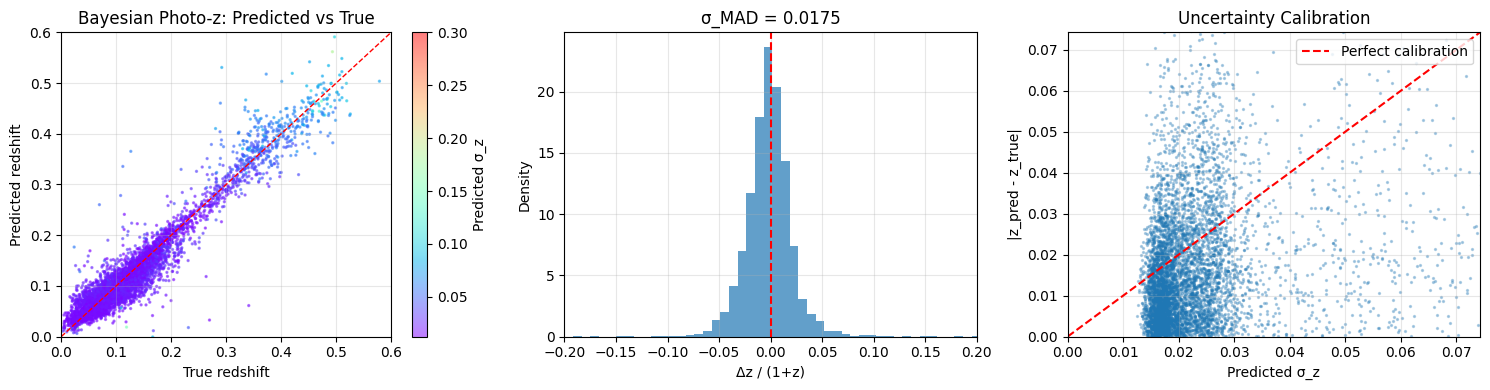


Done!


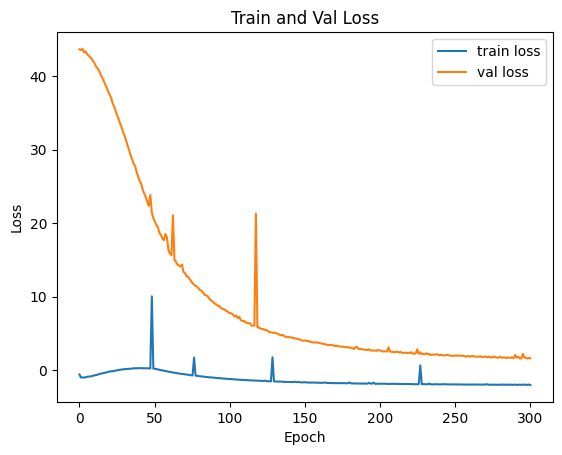

In [40]:
# -------------------------------------------------------------------------
# Plots
# -------------------------------------------------------------------------
print("\nGenerating plots...")

fig = plot_results(y_test, z_pred_mean, z_pred_std, title='Bayesian Photo-z')
plt.savefig('bayesian_photoz_results.png', dpi=150, bbox_inches='tight')
print("Saved: bayesian_photoz_results.png")

plt.show()
print("\nDone!")


plt.plot(np.linspace(0, len(train_losses), len(train_losses)), train_losses, label = 'train loss',zorder = 10)
plt.plot(np.linspace(0, len(val_losses), len(val_losses)), val_losses, label = 'val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.show()

In [41]:
# -------------------------------------------------------------------------
# Create and train model --- ADDITIONAL WORK --- Phot ERR is used
# -------------------------------------------------------------------------
print("\n" + "=" * 40)
print("\nADDITIONAL WORK")
print("\nCreating Bayesian Photo-z model with photometry err...")

model_ERR = BayesianPhotoZ(
    n_bands=5,
    hidden_dim=64,
    n_hidden=3,
    prior_std=1.0,
    use_errors=True, #not used first
    heteroscedastic=True
).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model_ERR.parameters()):,}")

print("\nTraining...")
train_losses_ERR, val_losses_ERR = train_bayesian_photoz(
    model_ERR, train_loader, val_loader,
    epochs=300,
    lr=1e-3,
    kl_anneal_epochs=50
)

# -------------------------------------------------------------------------
# Evaluate
# -------------------------------------------------------------------------
print("\nEvaluating on test set...")

model_ERR.eval()

print("Running Monte Carlo sampling for uncertainty...")
samples_ERR = model_ERR.predictive_samples(x_test_tensor,photo_err= err_test_tensor, n_samples=100)

# Convert back to original scale
z_pred_mc_ERR = samples_ERR.cpu().numpy().squeeze()  # Shape: (100, n_test)
z_pred_mean_ERR = z_pred_mc_ERR.mean(axis=0).reshape(-1, 1).flatten()
z_pred_std_ERR = z_pred_mc_ERR.std(axis=0)# * scaler_y.scale_[0]

# Metrics
delta_z_ERR = (z_pred_mean_ERR - y_test) / (1 + y_test)
rmse_ERR = np.sqrt(np.mean((z_pred_mean_ERR - y_test)**2))
sigma_mad_ERR = 1.4826 * np.median(np.abs(delta_z_ERR))
outlier_frac_ERR = np.mean(np.abs(delta_z_ERR) > 0.15)

print(f"\nResults:")
print(f"  RMSE: {rmse_ERR:.4f}")
print(f"  σ_MAD: {sigma_mad_ERR:.4f}")
print(f"  Outlier fraction: {outlier_frac_ERR:.1%}")
print(f"  Mean uncertainty: {z_pred_std_ERR.mean():.4f}")

# Calibration
within_1sig_ERR = np.mean(np.abs(z_pred_mean_ERR - y_test) < z_pred_std_ERR)
within_2sig_ERR = np.mean(np.abs(z_pred_mean_ERR - y_test) < 2 * z_pred_std_ERR)
print(f"\nCalibration:")
print(f"  Coverage 1σ: {within_1sig_ERR:.1%} (target: 68%)")
print(f"  Coverage 2σ: {within_2sig_ERR:.1%} (target: 95%)")

# -------------------------------------------------------------------------
# Metrics
# -------------------------------------------------------------------------
print("\n" + "=" * 40)
print("RESULTS")
print("=" * 40)

metrics_ERR = compute_photoz_metrics(y_test, z_pred_mean_ERR, z_pred_std_ERR)

for key, value in metrics_ERR.items():
    if 'coverage' in key or 'fraction' in key:
        print(f"{key}: {value:.1%}")
    else:
        print(f"{key}: {value:.4f}")





ADDITIONAL WORK

Creating Bayesian Photo-z model with photometry err...

Model architecture:
BayesianPhotoZ(
  (layers): ModuleList(
    (0-3): 4 x BayesianLinear()
  )
)

Total parameters: 18,308

Training...


Training: 100%|██████████| 300/300 [12:50<00:00,  2.57s/it, Train=-1.9578, Val=1.6759, KL_w=1.00, LR=0.001000]



Evaluating on test set...
Running Monte Carlo sampling for uncertainty...

Results:
  RMSE: 0.0269
  σ_MAD: 0.0186
  Outlier fraction: 0.1%
  Mean uncertainty: 0.0249

Calibration:
  Coverage 1σ: 70.0% (target: 68%)
  Coverage 2σ: 94.7% (target: 95%)

RESULTS
bias: -0.0041
sigma_MAD: 0.0183
NMAD: 0.0186
outlier_fraction: 0.1%
RMSE: 0.0269
coverage_1sigma: 70.0%
coverage_2sigma: 94.7%
mean_uncertainty: 0.0249



Generating plots...
Saved: bayesian_photoz_results_ERR.png


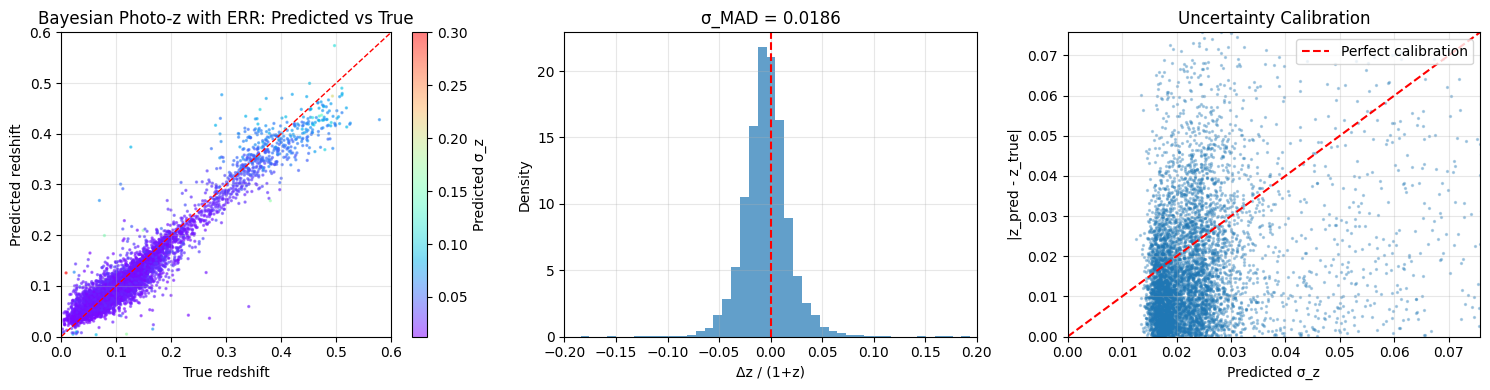


Done!


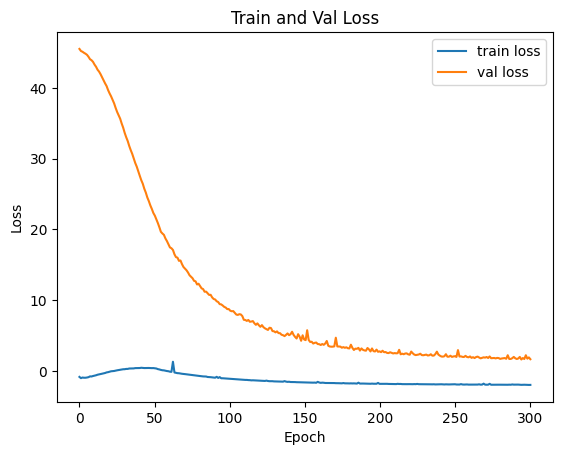

In [42]:
# -------------------------------------------------------------------------
# Plots
# -------------------------------------------------------------------------
print("\nGenerating plots...")

fig_ERR = plot_results(y_test, z_pred_mean_ERR, z_pred_std_ERR, title='Bayesian Photo-z with ERR')
plt.savefig('bayesian_photoz_results_ERR.png', dpi=150, bbox_inches='tight')
print("Saved: bayesian_photoz_results_ERR.png")

plt.show()
print("\nDone!")

plt.plot(np.linspace(0, len(train_losses_ERR), len(train_losses_ERR)), train_losses_ERR, label = 'train loss',zorder = 10)
plt.plot(np.linspace(0, len(val_losses_ERR), len(val_losses_ERR)), val_losses_ERR, label = 'val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.show()